In [1]:
import tensorflow as tf

Tensorflow, by default, runs code as chunks. So when you do the following, you don't get the answer you'd expect - it gives you a tensor object that hasn't actually been calculated yet.

In [5]:
x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
result = tf.multiply(x1, x2)
print(result)

Tensor("Mul_1:0", shape=(4,), dtype=int32)


Note that a constant is an assigned value that does not change. Placeholders are unassigned values that are initialized by the session when you run it. Variables are values that can change.

An interactive session in Tensorflow works more like Python.

In [6]:
x1 = tf.constant([1,2,3,4])
x2 = tf.constant([5,6,7,8])
result = tf.multiply(x1, x2)

sess = tf.Session()
print(sess.run(result))
sess.close()

[ 5 12 21 32]


Or alternatively:

In [7]:
with tf.Session() as sess:
    output = sess.run(result)
    print(output)

[ 5 12 21 32]


note that config=tf.ConfigProto(kwargs) can be used to configure the session

Now we write a function that loads in the data. This reads each file in the trainingand test sets.

In [25]:
import os
import skimage.io
import numpy as np

In [17]:
def load_data(data_directory):
    directories = [d for d in os.listdir(data_directory) 
                   if os.path.isdir(os.path.join(data_directory, d))]
    labels = []
    images = []
    for d in directories:
        label_directory = os.path.join(data_directory, d)
        file_names = [os.path.join(label_directory, f) 
                      for f in os.listdir(label_directory) 
                      if f.endswith(".ppm")]
        for f in file_names:
            images.append(skimage.io.imread(f))
            labels.append(int(d))
    return images, labels

In [36]:
images, labels = load_data("Training")

In [37]:
images = np.array(images)
labels = np.array(labels)

In [38]:
print(len(labels))
print(len(set(labels)))

4575
62


Looks like we have 62 distinct labels

In [41]:
print(images.size)

4575


And the number of images matches the number of labels - always good to check!

The distribution of label classes:

In [46]:
import matplotlib.pyplot as plt

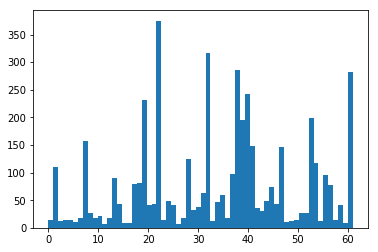

In [48]:
plt.hist(labels, 62)
plt.show()

Visualizing a few street signs:

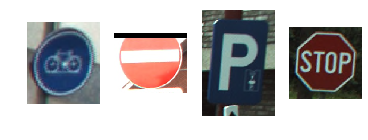

In [63]:
select_signs = [310, 2250, 3900, 4000]

for i in range(len(select_signs)):
    plt.subplot(1, 4, i+1)
    plt.imshow(images[select_signs[i]])
    plt.axis('off')
plt.show()

The images are different sizes - will this be problematic in the future? We'll see!

What are all the signs we have?

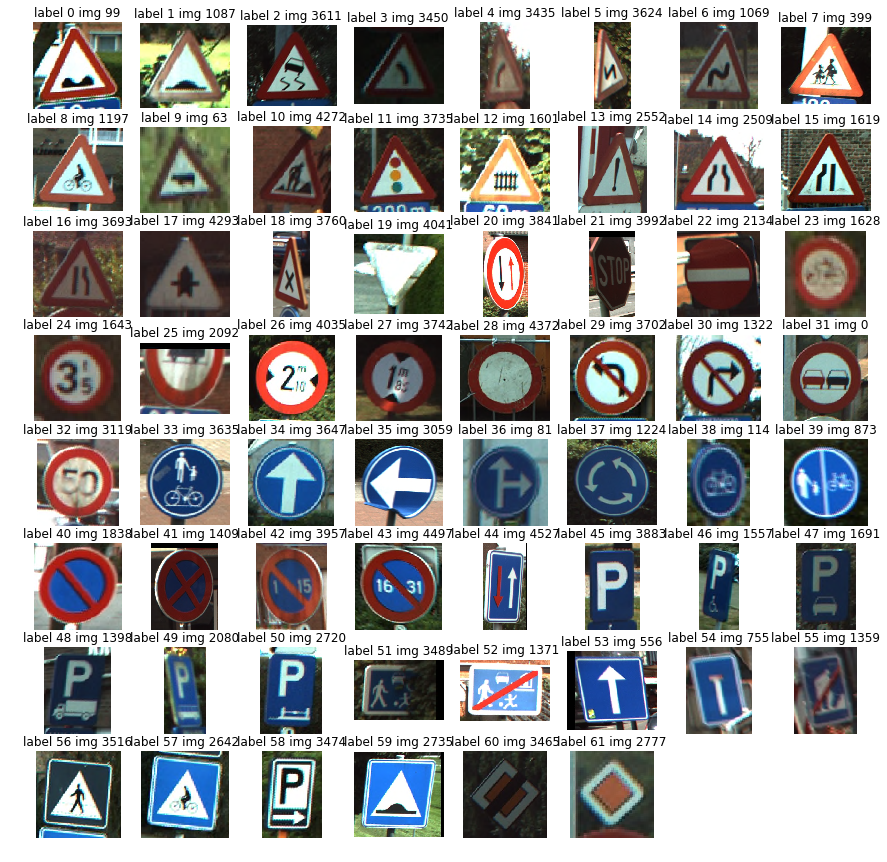

In [80]:
unique_labels = set(labels)
plt.figure(figsize=(15,15))

i=1
for label in unique_labels:
    indx = np.where(labels==label)[0][0]
    image = images[indx]
    plt.subplot(8, 8, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title("label {} img {}".format(label, indx))
    i=i+1
plt.show()

Now we're going to scale the images so they're all the same dimensions

In [81]:
from skimage import transform

In [82]:
images28 = [transform.resize(image, (28,28)) for image in images]

/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda3/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


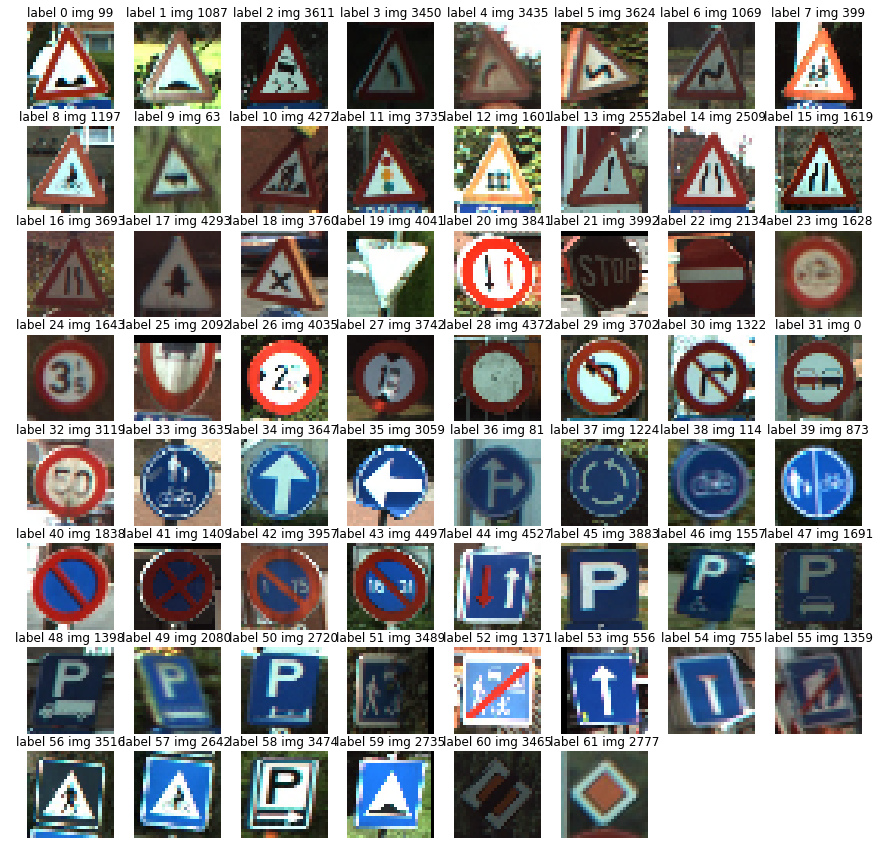

In [83]:
unique_labels = set(labels)
plt.figure(figsize=(15,15))

i=1
for label in unique_labels:
    indx = np.where(labels==label)[0][0]
    image = images28[indx]
    plt.subplot(8, 8, i)
    plt.imshow(image)
    plt.axis('off')
    plt.title("label {} img {}".format(label, indx))
    i=i+1
plt.show()

Convert to grayscale. For classification, this is supposed to work better. For detection, color is generally better.

In [84]:
from skimage.color import rgb2gray

In [85]:
images28 = np.array(images28)
images28 = rgb2gray(images28)

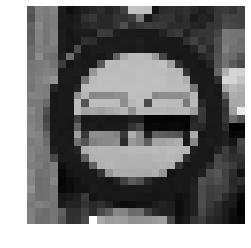

In [87]:
plt.imshow(images28[0], cmap='gray')
plt.axis('off')
plt.show()

Building the neural network:

This makes a new graph, and then makes that graph the default (if you don't do this, the layers just get added to a global default graph)

In [92]:
graph = tf.Graph()
graph = graph.as_default()

Building the layers:

In [88]:
# Initialize placeholders 
x = tf.placeholder(dtype = tf.float32, shape = [None, 28, 28])
y = tf.placeholder(dtype = tf.int32, shape = [None])

# Flatten the input data
images_flat = tf.contrib.layers.flatten(x)

# Fully connected layer 
logits = tf.contrib.layers.fully_connected(images_flat, 62, tf.nn.relu)

# Define a loss function
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = y, 
                                                                    logits = logits))
# Define an optimizer 
train_op = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

# Convert logits to label indexes
correct_pred = tf.argmax(logits, 1)

# Define an accuracy metric
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [89]:
print("images_flat: ", images_flat)
print("logits: ", logits)
print("loss: ", loss)
print("predicted_labels: ", correct_pred)

images_flat:  Tensor("Flatten/flatten/Reshape:0", shape=(?, 784), dtype=float32)
logits:  Tensor("fully_connected/Relu:0", shape=(?, 62), dtype=float32)
loss:  Tensor("Mean:0", shape=(), dtype=float32)
predicted_labels:  Tensor("ArgMax:0", shape=(?,), dtype=int64)


Running the network:

In [ ]:
tf.set_random_seed(1234)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

for i in range(201):
        print('EPOCH', i)
        _, accuracy_val = sess.run([train_op, accuracy], feed_dict={x: images28, y: labels})
        if i % 10 == 0:
            print("Loss: ", loss)
        print('DONE WITH EPOCH')